In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import itertools
import gensim
import re
import os
from collections import Counter
import logging
import warnings
import time
import pickle
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\SRAVAN\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SRAVAN\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SRAVAN\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SRAVAN\Anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SRAVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
df = pd.read_csv('data/tweettrain.csv', encoding = DATASET_ENCODING, names = DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [6]:
df.shape

(1600000, 6)

In [7]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [8]:
df.flag.value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

In [9]:
df.user.value_counts()

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
daviddayz            1
SammiLeeSaysHi       1
DJTURBULENCE         1
gbfred               1
fakesharon           1
Name: user, Length: 659775, dtype: int64

In [10]:
decode_map = {0:"NEGATIVE", 2:"NEUTRAL", 4:"POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
df['target'] = df['target'].apply(lambda x: decode_sentiment(x))

In [12]:
df.target.value_counts()

POSITIVE    800000
NEGATIVE    800000
Name: target, dtype: int64

In [13]:
Counter(df.target)

Counter({'NEGATIVE': 800000, 'POSITIVE': 800000})

Text(0.5, 1.0, 'Dataset labels distribution')

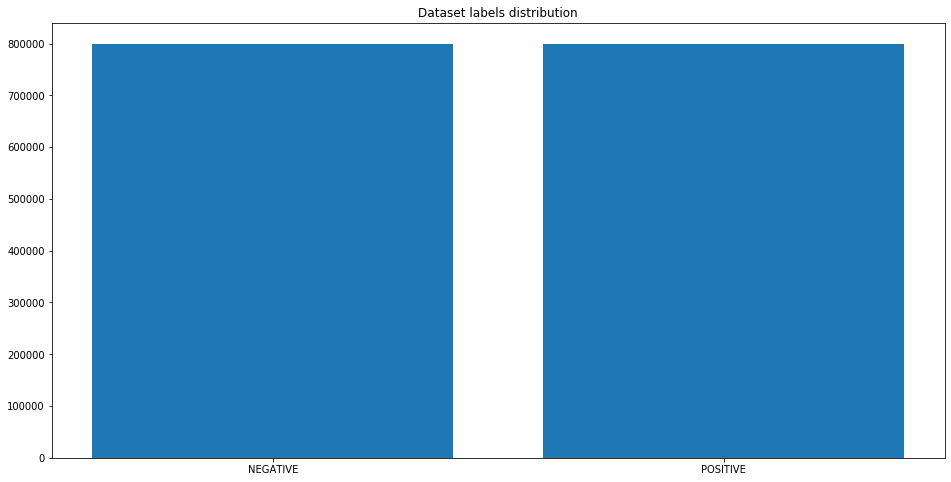

In [14]:
dictt = Counter(df.target)
plt.figure(figsize = (16, 8))
plt.bar(dictt.keys(), dictt.values())
plt.title('Dataset labels distribution')

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
stemmer

In [18]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 53s


In [20]:
df_train, df_test = train_test_split(df, test_size = 1-TRAIN_SIZE, random_state = 42)
print(df_train.shape)
print(df_test.shape)

(1280000, 6)
(320000, 6)


In [21]:
%%time
documents = [text.split() for text in df_train.text] 

Wall time: 4.24 s


In [22]:
print(documents[:1000])

[['ya', 'quot', 'like', 'palm', 'pre', 'touchstone', 'charger', 'readynow', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch'], ['felt', 'earthquake', 'afternoon', 'seems', 'epicenter'], ['ruffles', 'shirts', 'like', 'likey'], ['pretty', 'bad', 'night', 'crappy', 'morning', 'fml', 'buttface', 'didnt', 'say', 'could', 'go', 'work', 'today'], ['yeah', 'clear', 'view'], ['one', 'time', 'follow', 'fam', 'ff', 'georgeann13', 'nakithebeatman', 'flimackgod', 'chaz81', 'djt', 'elle', 'jaejaedynomite', 'welcome', 'friday', 'follow', '2'], ['u', 'rock', 'thanks', 'added', 'next', 'robcrotch', 'tm', 'video'], ['yes', 'please', 'met', 'fiancee', 'ian', 'party', 'day', 'btw', 'sweet', 'congrats', 'guys'], ['gawd', 'finished', 'whole', 'bowl', 'even', 'posted', 'previous', 'tweet', 'making', '2nd', 'bowl'], ['awesome', 'game', 'short', 'finish', 'craving', 'god', 'war', 'action'], ['happy', 'mothers', 'day', 'grown', 'n', 'happy', 'amp', 'lil', 'prego', 'smuts', 'lol', 'playing', 'everyone', 'lo

In [23]:
w2v_model = gensim.models.word2vec.Word2Vec(size = W2V_SIZE, window = W2V_WINDOW, 
                                            min_count = W2V_MIN_COUNT, workers=8)

In [24]:
w2v_model.build_vocab(documents)

2020-06-21 09:12:02,530 : INFO : collecting all words and their counts
2020-06-21 09:12:02,533 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-21 09:12:02,581 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-06-21 09:12:02,619 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-06-21 09:12:02,657 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-06-21 09:12:02,717 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-06-21 09:12:02,749 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-06-21 09:12:02,775 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-06-21 09:12:02,807 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-06-21 09:12:02,853 : INFO : PROGRESS: at s

2020-06-21 09:12:05,991 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-06-21 09:12:06,053 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-06-21 09:12:06,109 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-06-21 09:12:06,154 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-06-21 09:12:06,209 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-06-21 09:12:06,253 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-06-21 09:12:06,306 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-06-21 09:12:06,352 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-06-21 09:12:06,395 : INFO : PROGRESS: at sentence #800000, processed 577088

In [25]:
words = w2v_model.wv.vocab.keys()
words

dict_keys(['ya', 'quot', 'like', 'palm', 'pre', 'charger', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch', 'felt', 'earthquake', 'afternoon', 'seems', 'shirts', 'likey', 'pretty', 'bad', 'night', 'crappy', 'morning', 'fml', 'didnt', 'say', 'could', 'go', 'work', 'today', 'yeah', 'clear', 'view', 'one', 'time', 'follow', 'fam', 'ff', 'elle', 'welcome', 'friday', '2', 'u', 'rock', 'thanks', 'added', 'next', 'tm', 'video', 'please', 'met', 'fiancee', 'ian', 'party', 'day', 'btw', 'sweet', 'congrats', 'guys', 'gawd', 'finished', 'whole', 'bowl', 'even', 'posted', 'previous', 'tweet', 'making', '2nd', 'awesome', 'game', 'short', 'finish', 'craving', 'god', 'war', 'action', 'happy', 'mothers', 'grown', 'n', 'amp', 'lil', 'prego', 'lol', 'playing', 'everyone', 'loved', 'bless', 'back', 'eating', 'dinner', 'chat', 'room', 'many', 'heck', 'way', 'heights', 'want', 'trade', 'tired', 'saying', 'goodbye', 'chicago', 'stole', 'half', '12', 'mai', 'tai', 'inbound', 'suddenly', 'trouble', 'rel

In [26]:
vocab_size = len(words)
vocab_size

30369

In [27]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-06-21 09:12:23,377 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-06-21 09:12:24,463 : INFO : EPOCH 1 - PROGRESS: at 5.65% examples, 446557 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:12:25,486 : INFO : EPOCH 1 - PROGRESS: at 11.73% examples, 467248 words/s, in_qsize 15, out_qsize 1
2020-06-21 09:12:26,495 : INFO : EPOCH 1 - PROGRESS: at 18.11% examples, 484694 words/s, in_qsize 13, out_qsize 2
2020-06-21 09:12:27,531 : INFO : EPOCH 1 - PROGRESS: at 24.50% examples, 490525 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:12:28,537 : INFO : EPOCH 1 - PROGRESS: at 30.67% examples, 493375 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:12:29,553 : INFO : EPOCH 1 - PROGRESS: at 36.83% examples, 494411 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:12:30,561 : INFO : EPOCH 1 - PROGRESS: at 43.21% examples, 498208 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:12:31,620 : INFO : EPOCH 1 - PROGRESS: 

2020-06-21 09:13:14,424 : INFO : EPOCH 4 - PROGRESS: at 5.11% examples, 417601 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:13:15,461 : INFO : EPOCH 4 - PROGRESS: at 11.19% examples, 450195 words/s, in_qsize 16, out_qsize 1
2020-06-21 09:13:16,468 : INFO : EPOCH 4 - PROGRESS: at 17.24% examples, 464977 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:13:17,492 : INFO : EPOCH 4 - PROGRESS: at 22.87% examples, 461840 words/s, in_qsize 15, out_qsize 1
2020-06-21 09:13:18,509 : INFO : EPOCH 4 - PROGRESS: at 29.37% examples, 474536 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:13:19,565 : INFO : EPOCH 4 - PROGRESS: at 34.46% examples, 461144 words/s, in_qsize 13, out_qsize 2
2020-06-21 09:13:20,590 : INFO : EPOCH 4 - PROGRESS: at 40.73% examples, 467226 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:13:21,630 : INFO : EPOCH 4 - PROGRESS: at 46.57% examples, 466697 words/s, in_qsize 16, out_qsize 1
2020-06-21 09:13:22,637 : INFO : EPOCH 4 - PROGRESS: at 53.05% examples, 473707 words/s, 

2020-06-21 09:14:07,136 : INFO : EPOCH 7 - PROGRESS: at 17.57% examples, 467180 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:14:08,157 : INFO : EPOCH 7 - PROGRESS: at 23.30% examples, 466210 words/s, in_qsize 16, out_qsize 2
2020-06-21 09:14:09,162 : INFO : EPOCH 7 - PROGRESS: at 29.48% examples, 473896 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:14:10,182 : INFO : EPOCH 7 - PROGRESS: at 35.32% examples, 473527 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:14:11,222 : INFO : EPOCH 7 - PROGRESS: at 41.16% examples, 471915 words/s, in_qsize 16, out_qsize 2
2020-06-21 09:14:12,263 : INFO : EPOCH 7 - PROGRESS: at 47.10% examples, 471772 words/s, in_qsize 16, out_qsize 4
2020-06-21 09:14:13,271 : INFO : EPOCH 7 - PROGRESS: at 54.03% examples, 482090 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:14:14,294 : INFO : EPOCH 7 - PROGRESS: at 59.98% examples, 481814 words/s, in_qsize 16, out_qsize 1
2020-06-21 09:14:15,314 : INFO : EPOCH 7 - PROGRESS: at 66.47% examples, 485581 words/s,

2020-06-21 09:14:59,948 : INFO : EPOCH 10 - PROGRESS: at 28.72% examples, 459028 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:15:00,951 : INFO : EPOCH 10 - PROGRESS: at 34.46% examples, 460871 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:15:01,998 : INFO : EPOCH 10 - PROGRESS: at 40.62% examples, 464372 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:15:03,001 : INFO : EPOCH 10 - PROGRESS: at 46.35% examples, 465172 words/s, in_qsize 14, out_qsize 1
2020-06-21 09:15:04,020 : INFO : EPOCH 10 - PROGRESS: at 52.51% examples, 468861 words/s, in_qsize 14, out_qsize 1
2020-06-21 09:15:05,039 : INFO : EPOCH 10 - PROGRESS: at 58.79% examples, 472694 words/s, in_qsize 14, out_qsize 1
2020-06-21 09:15:06,113 : INFO : EPOCH 10 - PROGRESS: at 64.84% examples, 471864 words/s, in_qsize 15, out_qsize 3
2020-06-21 09:15:07,148 : INFO : EPOCH 10 - PROGRESS: at 71.56% examples, 477042 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:15:08,171 : INFO : EPOCH 10 - PROGRESS: at 77.63% examples, 477831

2020-06-21 09:15:51,900 : INFO : EPOCH 13 - PROGRESS: at 35.97% examples, 481090 words/s, in_qsize 15, out_qsize 1
2020-06-21 09:15:52,906 : INFO : EPOCH 13 - PROGRESS: at 42.13% examples, 484369 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:15:53,986 : INFO : EPOCH 13 - PROGRESS: at 47.65% examples, 476035 words/s, in_qsize 15, out_qsize 2
2020-06-21 09:15:54,999 : INFO : EPOCH 13 - PROGRESS: at 54.03% examples, 480720 words/s, in_qsize 14, out_qsize 1
2020-06-21 09:15:56,024 : INFO : EPOCH 13 - PROGRESS: at 59.87% examples, 479618 words/s, in_qsize 14, out_qsize 1
2020-06-21 09:15:57,052 : INFO : EPOCH 13 - PROGRESS: at 66.15% examples, 481674 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:15:58,067 : INFO : EPOCH 13 - PROGRESS: at 72.10% examples, 481781 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:15:59,103 : INFO : EPOCH 13 - PROGRESS: at 78.07% examples, 481063 words/s, in_qsize 16, out_qsize 1
2020-06-21 09:16:00,120 : INFO : EPOCH 13 - PROGRESS: at 84.15% examples, 481718

2020-06-21 09:16:43,487 : INFO : EPOCH 16 - PROGRESS: at 67.88% examples, 612263 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:16:44,511 : INFO : EPOCH 16 - PROGRESS: at 75.24% examples, 610154 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:16:45,539 : INFO : EPOCH 16 - PROGRESS: at 82.53% examples, 607386 words/s, in_qsize 16, out_qsize 4
2020-06-21 09:16:46,585 : INFO : EPOCH 16 - PROGRESS: at 90.22% examples, 607121 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:16:47,617 : INFO : EPOCH 16 - PROGRESS: at 97.93% examples, 607560 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:16:47,793 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-21 09:16:47,803 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-21 09:16:47,805 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-21 09:16:47,821 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-21 09:16:47,838 : INFO : worker thread finished; awai

2020-06-21 09:17:35,280 : INFO : EPOCH 19 - PROGRESS: at 83.72% examples, 479887 words/s, in_qsize 14, out_qsize 1
2020-06-21 09:17:36,311 : INFO : EPOCH 19 - PROGRESS: at 90.11% examples, 481838 words/s, in_qsize 16, out_qsize 2
2020-06-21 09:17:37,370 : INFO : EPOCH 19 - PROGRESS: at 96.42% examples, 482229 words/s, in_qsize 16, out_qsize 2
2020-06-21 09:17:37,731 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-21 09:17:37,738 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-21 09:17:37,739 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-21 09:17:37,741 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-21 09:17:37,770 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-21 09:17:37,774 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-21 09:17:37,775 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-21 09:17:3

2020-06-21 09:18:26,834 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-21 09:18:26,836 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-21 09:18:26,862 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-21 09:18:26,877 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-21 09:18:26,882 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-21 09:18:26,895 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-21 09:18:26,918 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-21 09:18:26,926 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-21 09:18:26,928 : INFO : EPOCH - 22 : training on 9227204 raw words (8222907 effective words) took 16.7s, 492152 effective words/s
2020-06-21 09:18:27,967 : INFO : EPOCH 23 - PROGRESS: at 5.00% examples, 404591 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:18:28

2020-06-21 09:19:15,435 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-21 09:19:15,437 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-21 09:19:15,441 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-21 09:19:15,443 : INFO : EPOCH - 25 : training on 9227204 raw words (8223346 effective words) took 16.2s, 507543 effective words/s
2020-06-21 09:19:16,498 : INFO : EPOCH 26 - PROGRESS: at 5.32% examples, 422207 words/s, in_qsize 16, out_qsize 2
2020-06-21 09:19:17,500 : INFO : EPOCH 26 - PROGRESS: at 11.62% examples, 468501 words/s, in_qsize 16, out_qsize 1
2020-06-21 09:19:18,565 : INFO : EPOCH 26 - PROGRESS: at 17.68% examples, 468297 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:19:19,570 : INFO : EPOCH 26 - PROGRESS: at 24.06% examples, 481673 words/s, in_qsize 16, out_qsize 1
2020-06-21 09:19:20,581 : INFO : EPOCH 26 - PROGRESS: at 30.56% examples, 490918 words/s, in_qsize 16, out_qsize 1
2020-06-21 09:

2020-06-21 09:20:05,604 : INFO : EPOCH 29 - PROGRESS: at 5.00% examples, 398171 words/s, in_qsize 14, out_qsize 2
2020-06-21 09:20:06,630 : INFO : EPOCH 29 - PROGRESS: at 11.95% examples, 477183 words/s, in_qsize 15, out_qsize 2
2020-06-21 09:20:07,673 : INFO : EPOCH 29 - PROGRESS: at 18.54% examples, 491724 words/s, in_qsize 16, out_qsize 2
2020-06-21 09:20:08,686 : INFO : EPOCH 29 - PROGRESS: at 24.61% examples, 492004 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:20:09,717 : INFO : EPOCH 29 - PROGRESS: at 30.35% examples, 485287 words/s, in_qsize 16, out_qsize 2
2020-06-21 09:20:10,735 : INFO : EPOCH 29 - PROGRESS: at 35.86% examples, 478786 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:20:11,772 : INFO : EPOCH 29 - PROGRESS: at 41.80% examples, 477871 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:20:12,805 : INFO : EPOCH 29 - PROGRESS: at 48.08% examples, 480632 words/s, in_qsize 14, out_qsize 1
2020-06-21 09:20:13,846 : INFO : EPOCH 29 - PROGRESS: at 53.92% examples, 478540 

2020-06-21 09:20:57,086 : INFO : EPOCH 32 - PROGRESS: at 11.08% examples, 439715 words/s, in_qsize 13, out_qsize 2
2020-06-21 09:20:58,088 : INFO : EPOCH 32 - PROGRESS: at 17.24% examples, 461320 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:20:59,153 : INFO : EPOCH 32 - PROGRESS: at 23.41% examples, 465389 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:21:00,222 : INFO : EPOCH 32 - PROGRESS: at 29.91% examples, 472515 words/s, in_qsize 15, out_qsize 0
2020-06-21 09:21:01,266 : INFO : EPOCH 32 - PROGRESS: at 35.65% examples, 469098 words/s, in_qsize 15, out_qsize 1
2020-06-21 09:21:02,333 : INFO : EPOCH 32 - PROGRESS: at 42.67% examples, 479867 words/s, in_qsize 15, out_qsize 2
2020-06-21 09:21:03,359 : INFO : EPOCH 32 - PROGRESS: at 49.06% examples, 483815 words/s, in_qsize 16, out_qsize 0
2020-06-21 09:21:04,385 : INFO : EPOCH 32 - PROGRESS: at 54.89% examples, 482274 words/s, in_qsize 16, out_qsize 3
2020-06-21 09:21:05,409 : INFO : EPOCH 32 - PROGRESS: at 61.28% examples, 485357

Wall time: 8min 48s


(263121424, 295270528)

In [28]:
w2v_model.most_similar("hi")

2020-06-21 09:21:11,679 : INFO : precomputing L2-norms of word weight vectors


[('hey', 0.6944657564163208),
 ('hello', 0.6854431629180908),
 ('hola', 0.5003343820571899),
 ('hiya', 0.49753260612487793),
 ('heyy', 0.4962955117225647),
 ('hiiii', 0.4631739854812622),
 ('hii', 0.4593544006347656),
 ('welcome', 0.4272202253341675),
 ('hy', 0.4182687997817993),
 ('hallo', 0.3974505662918091)]

In [29]:
w2v_model.most_similar("sad")

[('depressed', 0.5912920236587524),
 ('upset', 0.5596996545791626),
 ('bummed', 0.516383707523346),
 ('sadd', 0.473387211561203),
 ('sadder', 0.4616854190826416),
 ('bittersweet', 0.4464821219444275),
 ('devastated', 0.43211209774017334),
 ('heartbroken', 0.42375659942626953),
 ('cry', 0.4230753779411316),
 ('upsetting', 0.418815016746521)]

In [30]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 49.2 s


In [31]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 1min 9s


In [32]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [33]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [34]:
import numpy as np
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [35]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

2020-06-21 09:23:14,464 : WARNING : From C:\Users\SRAVAN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [36]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2020-06-21 09:23:14,813 : WARNING : From C:\Users\SRAVAN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2020-06-21 09:23:14,964 : WARNING : From C:\Users\SRAVAN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2020-06-21 09:23:15,056 : WARNING : From C:\Users\SRAVAN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2020-06-21 09:23:15,059 : WARNING : From C:\Users\SRAVAN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2020-06-21 09:23:21,141 : WARNING : From C:\Users\SRAVAN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

2020-06-21 09:23:22,744 : WARNING : From C:\Users\SRAVAN\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-06-21 09:23:22,829 : WARNING : From C:\Users\SRAVAN\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
 743424/1152000 [==================>...........] - ETA: 50:30 - loss: 0.5153 - acc: 0.7433

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()